Score the output of Melodia contours + ismir 2015 contour classifier on the full mixes in the medleydb test set against the melody2 annotations

**This was not used in the end**

In [1]:
import motif
import motif.plot
import numpy as np
import mir_eval
import os
import medleydb as mdb
import seaborn
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Get Train/Test/Validation sets

In [3]:
with open("../outputs/data_splits.json", 'r') as fhandle:
    dat_dict = json.load(fhandle)

def get_file_pairs(track_id_list):
    file_pairs = []
    for track_id in track_id_list:
        mtrack = mdb.MultiTrack(track_id)
        if mtrack.dataset_version != 'V1':
            continue
        npy_path = "../comparisons/multif0/experiment11b_output/fullmix_outputs/{}_prediction.npy".format(track_id)
        if os.path.exists(npy_path):
            file_pairs.append([mtrack.mix_path, mtrack.melody2_fpath, track_id])
    return file_pairs

file_pairs_train = get_file_pairs(dat_dict['train'])
file_pairs_validate = get_file_pairs(dat_dict['validate'])
file_pairs_test = get_file_pairs(dat_dict['test'])

ftr_bitt = motif.feature_extractors.BitteliFeatures()

### Get train/test/validate contours, features and labels

In [4]:
def get_XY_pairs(etr, ftr, file_pairs):
    contour_list = {}
    features_list = []
    labels_list = []

    for mix_path, annotation, track_id in file_pairs:
        print(track_id)
        ctr = etr.compute_contours(mix_path)
        Y_train, _ = ctr.compute_labels(annotation)
        X_train = ftr.compute_all(ctr)

        features_list.append(X_train)
        labels_list.append(Y_train)
        contour_list[track_id] = ctr

    X = np.concatenate(features_list)
    Y = np.concatenate(labels_list)
    return X, Y, contour_list

In [5]:
etr_sal = motif.contour_extractors.Salamon()

X_train_sal, Y_train_sal, train_contours_sal = \
    get_XY_pairs(etr_sal, ftr_bitt, file_pairs_train)
X_vaidate_sal, Y_validate_sal, validate_contours_sal = \
    get_XY_pairs(etr_sal, ftr_bitt, file_pairs_validate)
X_test_sal, Y_test_sal, test_contours_sal = \
    get_XY_pairs(etr_sal, ftr_bitt, file_pairs_test)

AimeeNorwich_Child


/usr/local/lib/python2.7/site-packages/mir_eval/melody.py:231: UserWarning: Non-uniform timescale passed to resample_melody_series.  Pitch will be linearly interpolated, which will result in undesirable behavior if silences are indicated by missing values.  Silences should be indicated by nonpositive frequency values.
  "Non-uniform timescale passed to resample_melody_series.  Pitch "
/usr/local/lib/python2.7/site-packages/mir_eval/melody.py:77: UserWarning: Reference melody has no voiced frames.
  warnings.warn("Reference melody has no voiced frames.")


AimeeNorwich_Flying
AlexanderRoss_GoodbyeBolero
AlexanderRoss_VelvetCurtain
AmarLal_Rest
AmarLal_SpringDay1
AvaLuna_Waterduct
BigTroubles_Phantom
ClaraBerryAndWooldog_AirTraffic
ClaraBerryAndWooldog_Boys
ClaraBerryAndWooldog_Stella
ClaraBerryAndWooldog_TheBadGuys
ClaraBerryAndWooldog_WaltzForMyVictims
CroqueMadame_Oil
CroqueMadame_Pilot
DreamersOfTheGhetto_HeavyLove
EthanHein_1930sSynthAndUprightBass
EthanHein_GirlOnABridge
FacesOnFilm_WaitingForGa
FamilyBand_Again
Handel_TornamiAVagheggiar
HeladoNegro_MitadDelMundo
HopAlong_SisterCities
InvisibleFamiliars_DisturbingWildlife
JoelHelander_Definition
JoelHelander_ExcessiveResistancetoChange
JoelHelander_IntheAtticBedroom
KarimDouaidy_Hopscotch
KarimDouaidy_Yatora
LizNelson_Coldwar
LizNelson_ImComingHome
LizNelson_Rainfall
Meaxic_TakeAStep
Meaxic_YouListen
MichaelKropf_AllGoodThings
Mozart_BesterJungling
MusicDelta_80sRock
MusicDelta_Beatles
MusicDelta_Beethoven
MusicDelta_Britpop
MusicDelta_ChineseChaoZhou
MusicDelta_ChineseDrama
MusicDe

In [16]:
X_vaidate_sal, Y_validate_sal, validate_contours_sal = \
    get_XY_pairs(etr_sal, ftr_bitt, file_pairs_validate)

BrandonWebster_DontHearAThing
BrandonWebster_YesSirICanFly
HezekiahJones_BorrowedHeart
MusicDelta_BebopJazz
MusicDelta_GriegTrolltog
MusicDelta_LatinJazz
MusicDelta_ModalJazz
SecretMountains_HighHorse
SweetLights_YouLetMeDown


### Train contour classifier

In [6]:
clf_sal = motif.contour_classifiers.RandomForest()
clf_sal.fit(X_train_sal, Y_train_sal)

### Compute classification scores

In [9]:
def score_classifier(clf, X, Y_true):
    Y_prob = clf.predict(X)
    Y_pred = (np.array(Y_prob >= clf.threshold)).astype(int)
    scores = clf.score(Y_pred, Y_true, y_prob=Y_prob)
    return scores

In [17]:
train_scores = score_classifier(clf_sal, X_train_sal, Y_train_sal)
validate_scores = score_classifier(clf_sal, X_vaidate_sal, Y_validate_sal)
test_scores = score_classifier(clf_sal, X_test_sal, Y_test_sal)

print(train_scores)
print(validate_scores)
print(test_scores)

{'f1': array([ 0.99711414,  0.98702852]), 'recall': array([ 0.99566728,  0.99351792]), 'support': array([48930, 10799]), 'mcc': 0.98417418885584507, 'precision': array([ 0.99856522,  0.98062334]), 'auc score': 0.99974543100865798, 'confusion matrix': array([[48718,   212],
       [   70, 10729]]), 'accuracy': 0.99527867535033232}
{'f1': array([ 0.89100511,  0.51817834]), 'recall': array([ 0.91047417,  0.47342657]), 'support': array([5652, 1430]), 'mcc': 0.41314878155346907, 'precision': array([ 0.87235125,  0.57227388]), 'auc score': 0.82793064154529117, 'confusion matrix': array([[5146,  506],
       [ 753,  677]]), 'accuracy': 0.82222536006777747}
{'f1': array([ 0.87950443,  0.52205006]), 'recall': array([ 0.93031785,  0.42908817]), 'support': array([20450,  6635]), 'mcc': 0.42407790070964513, 'precision': array([ 0.83395432,  0.66643258]), 'auc score': 0.83696486182226215, 'confusion matrix': array([[19025,  1425],
       [ 3788,  2847]]), 'accuracy': 0.80753184419420343}


### Get contour melody probabilities

In [12]:
def get_contour_melprobs(ftr, clf, contours_dict):
    scores = {}

    for trackid, ctr in contours_dict.items():
        print(trackid)
        X = ftr.compute_all(ctr)
        Y = clf.predict(X)
        scores[trackid] = Y

    return scores

In [18]:
validation_melprobs = get_contour_melprobs(
    ftr_bitt, clf_sal, validate_contours_sal
)
test_melprobs = get_contour_melprobs(
    ftr_bitt, clf_sal, test_contours_sal
)

MusicDelta_LatinJazz
MusicDelta_GriegTrolltog
SweetLights_YouLetMeDown
BrandonWebster_YesSirICanFly
SecretMountains_HighHorse
HezekiahJones_BorrowedHeart
MusicDelta_BebopJazz
BrandonWebster_DontHearAThing
MusicDelta_ModalJazz
Phoenix_SeanCaughlinsTheScartaglen
Schubert_Erstarrung
Phoenix_ColliersDaughter
AClassicEducation_NightOwl
Phoenix_LarkOnTheStrandDrummondCastle
ChrisJacoby_PigsFoot
Mozart_DiesBildnis
MatthewEntwistle_TheArch
Auctioneer_OurFutureFaces
MatthewEntwistle_DontYouEver
PortStWillow_StayEven
MusicDelta_FusionJazz
Phoenix_BrokenPledgeChicagoReel
MatthewEntwistle_FairerHopes
Debussy_LenfantProdigue
Creepoid_OldTree
MusicDelta_SwingJazz
MatthewEntwistle_Lontano
CelestialShore_DieForUs
MusicDelta_Pachelbel
ChrisJacoby_BoothShotLincoln
StrandOfOaks_Spacestation
Phoenix_ElzicsFarewell
MusicDelta_Gospel
MatthewEntwistle_ImpressionsOfSaturn
MatthewEntwistle_TheFlaxenField
Phoenix_ScotchMorris


### Get best probability threshold

In [50]:
reload(motif)
reload(motif.contour_decoders)
reload(motif.contour_decoders.maximum)

<module 'motif.contour_decoders.maximum' from '/Users/rabitt/Dropbox/MARL/repos/motif/motif/contour_decoders/maximum.pyc'>

In [51]:
dcd = motif.contour_decoders.MaxDecoder()
dcd.dummy()

derp derp derp


In [52]:
thresh_vals = np.arange(0, 0.4, 0.01)
mel_accuracy = {v: [] for v in thresh_vals}

for trackid in validate_contours_sal.keys():
    print(trackid)
    mtrack = mdb.MultiTrack(trackid)

    ctr = validate_contours_sal[trackid]
    scores = validation_melprobs[trackid]    
    
    mel2 = mtrack.melody2_annotation
    mel2 = np.array(mel2).T
    ref_times, ref_freqs = (mel2[0], mel2[1])

    for thresh in thresh_vals:
        dcd = motif.contour_decoders.MaxDecoder(thresh=thresh)
        est_times, est_freqs = dcd.decode(ctr, scores)

        mel_scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
        mel_accuracy[thresh].append(mel_scores['Overall Accuracy'])

MusicDelta_LatinJazz
MusicDelta_GriegTrolltog
SweetLights_YouLetMeDown
BrandonWebster_YesSirICanFly
SecretMountains_HighHorse
HezekiahJones_BorrowedHeart
MusicDelta_BebopJazz
BrandonWebster_DontHearAThing
MusicDelta_ModalJazz


In [53]:
accuracy_vals = [np.mean(mel_accuracy[thresh]) for thresh in thresh_vals]
best_thresh_idx = np.argmax(accuracy_vals)
best_thresh = thresh_vals[best_thresh_idx]

print("Best threshold is {} with an OA of {}".format(
    best_thresh, accuracy_vals[best_thresh_idx])
)

Best threshold is 0.39 with an OA of 0.446221178357


### Score Melody Outputs on Test Set

Phoenix_SeanCaughlinsTheScartaglen


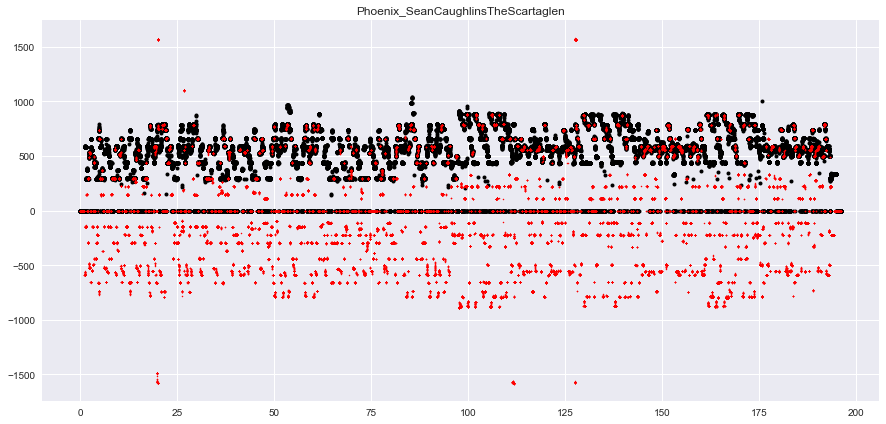

Schubert_Erstarrung


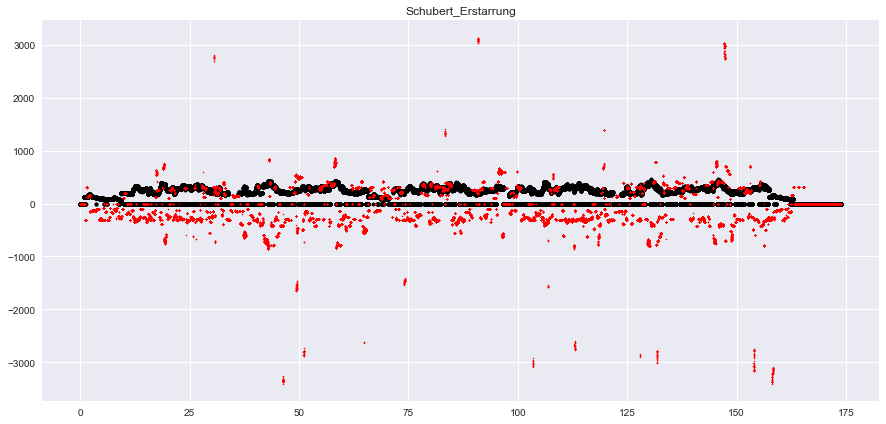

Phoenix_ColliersDaughter


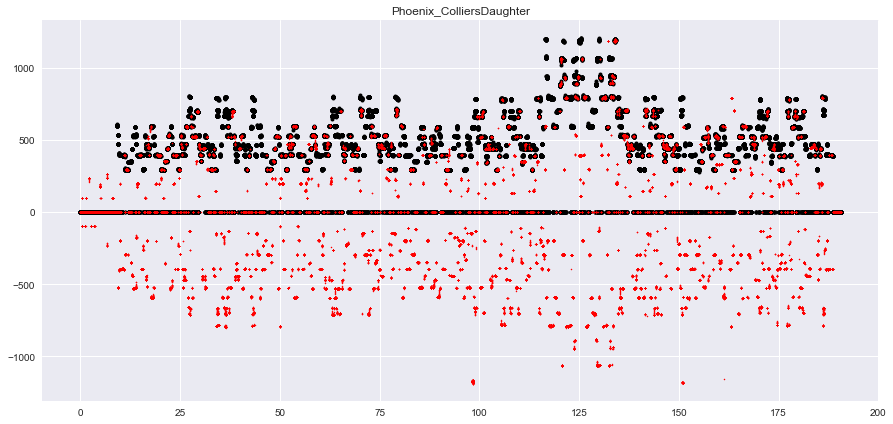

AClassicEducation_NightOwl


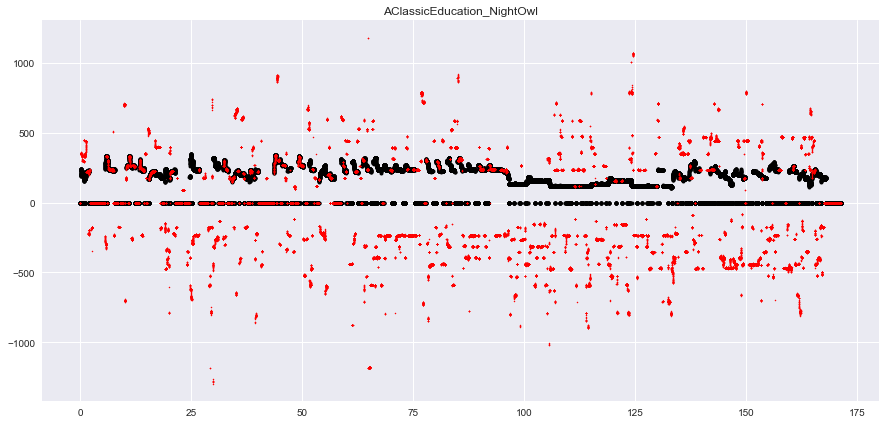

Phoenix_LarkOnTheStrandDrummondCastle


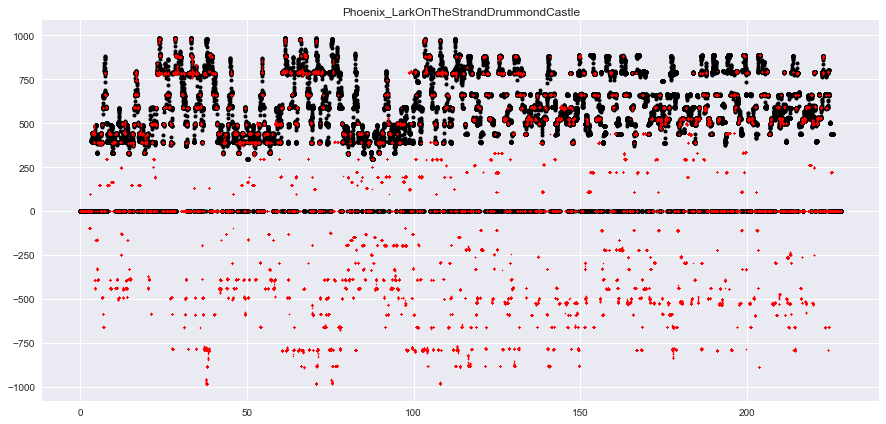

ChrisJacoby_PigsFoot


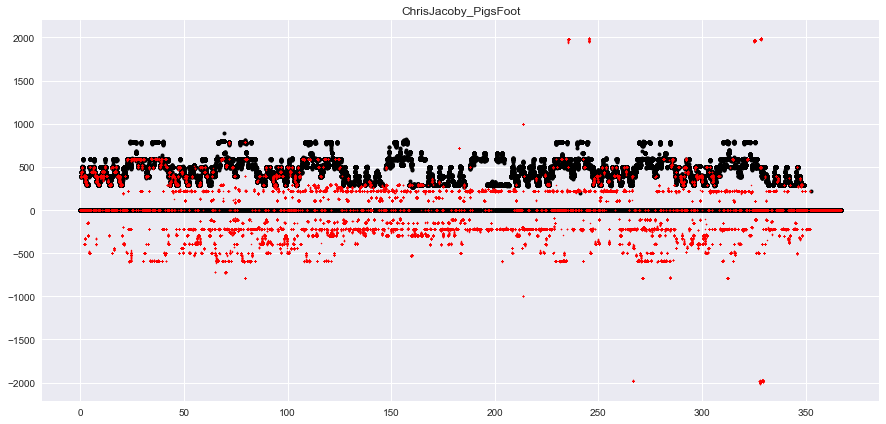

Mozart_DiesBildnis


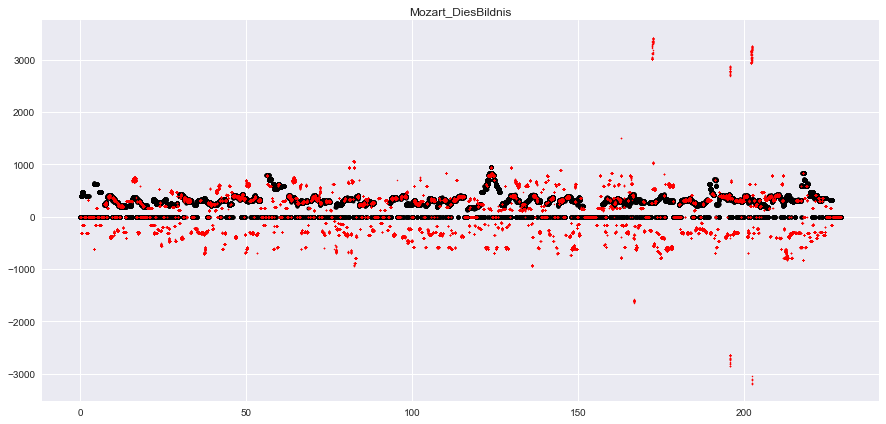

MatthewEntwistle_TheArch


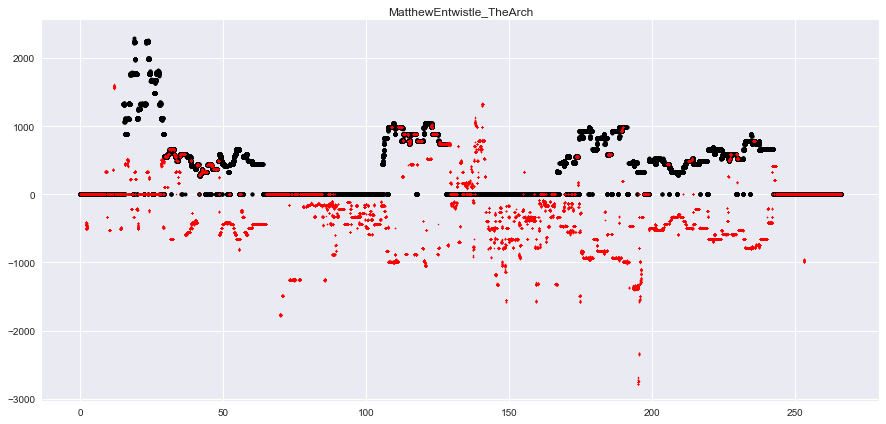

Auctioneer_OurFutureFaces


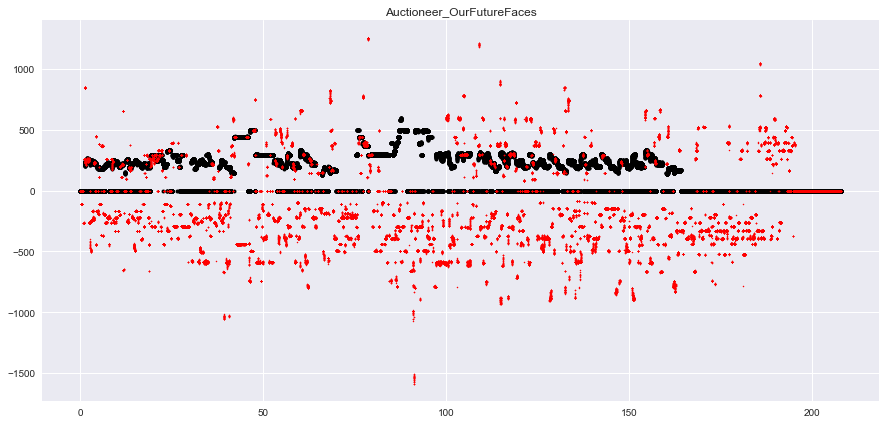

MatthewEntwistle_DontYouEver


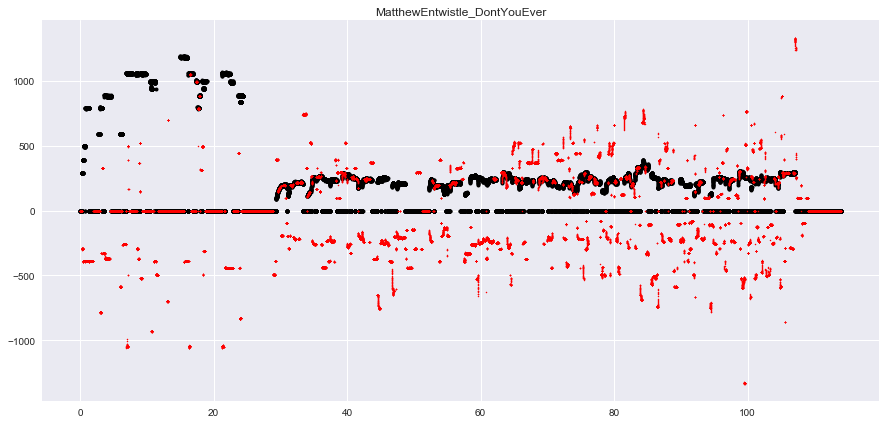

PortStWillow_StayEven


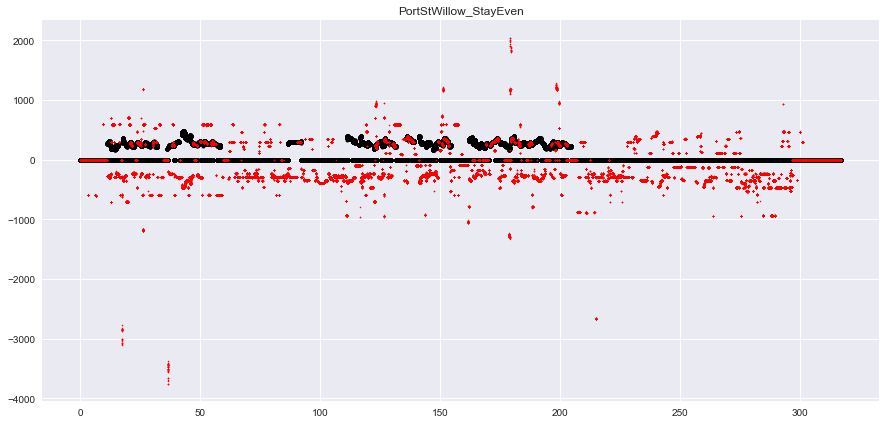

MusicDelta_FusionJazz


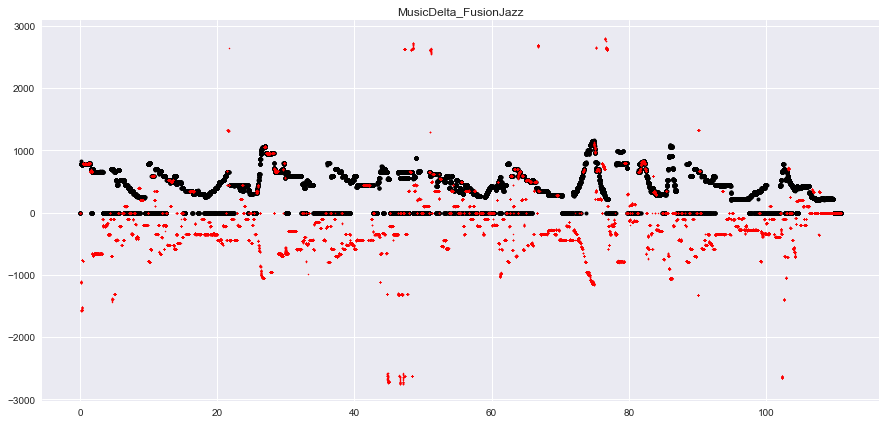

Phoenix_BrokenPledgeChicagoReel


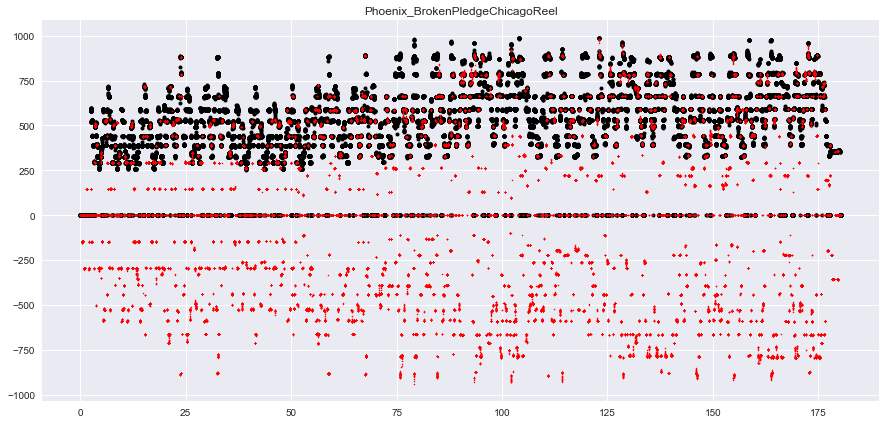

MatthewEntwistle_FairerHopes


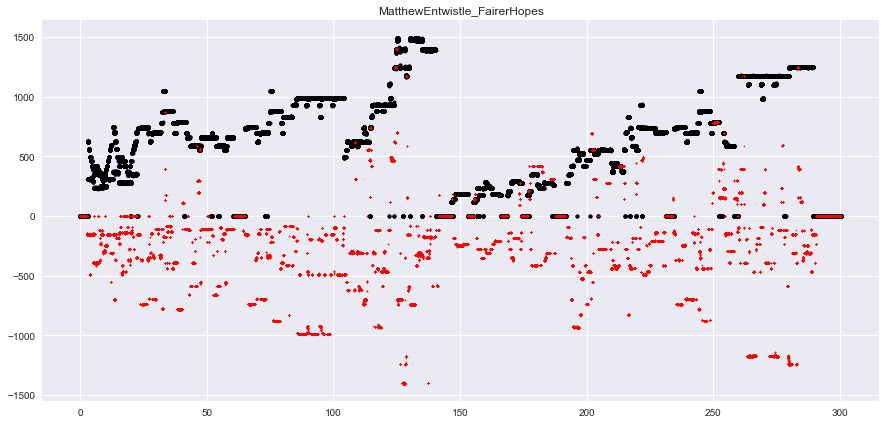

Debussy_LenfantProdigue


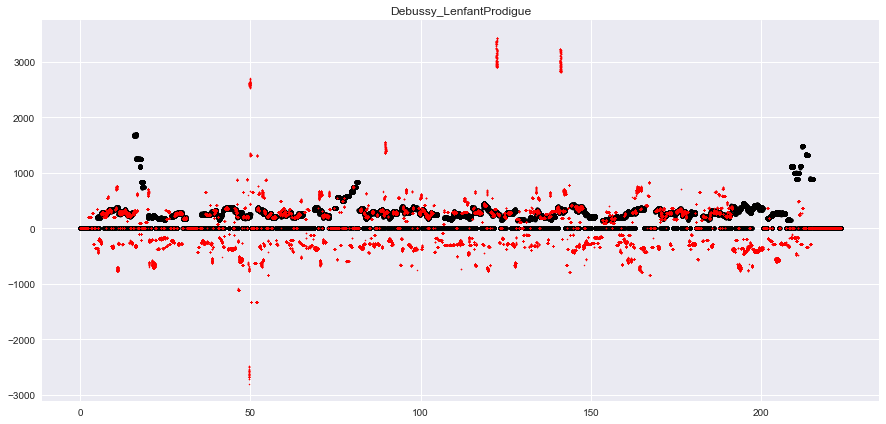

Creepoid_OldTree


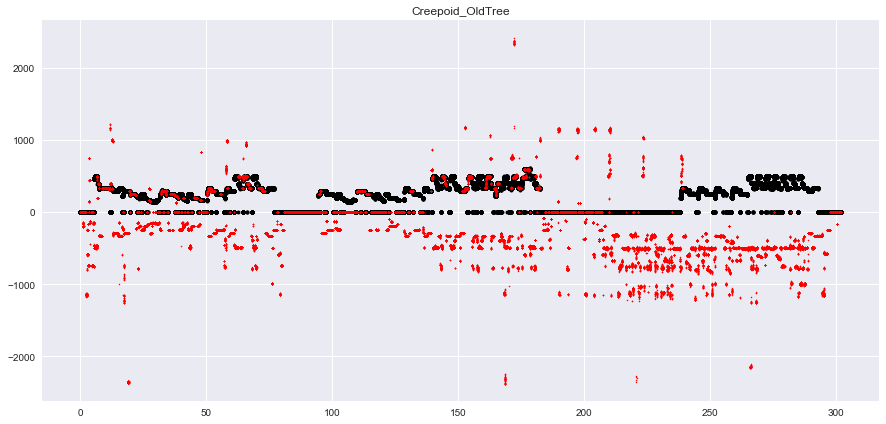

MusicDelta_SwingJazz


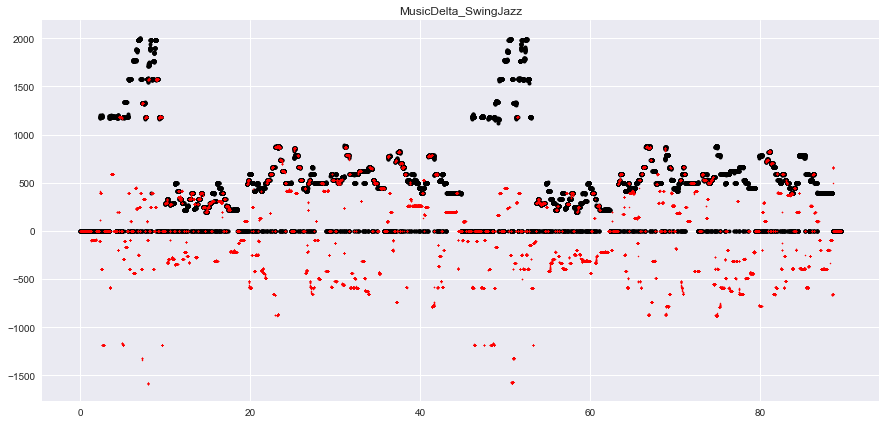

MatthewEntwistle_Lontano


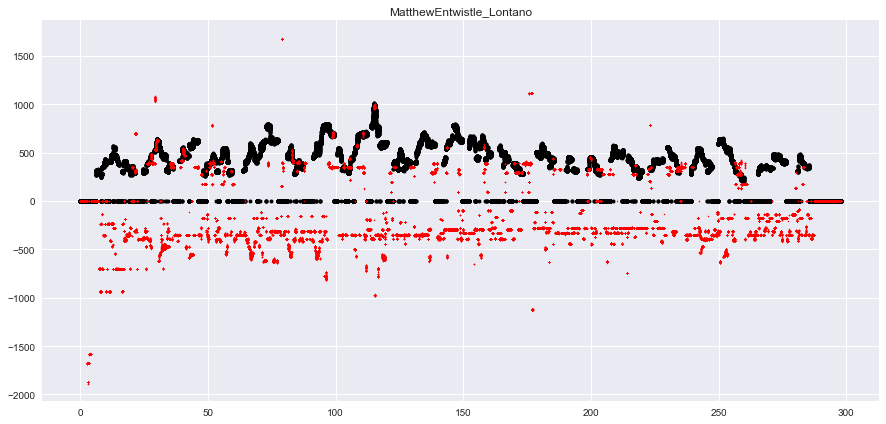

CelestialShore_DieForUs


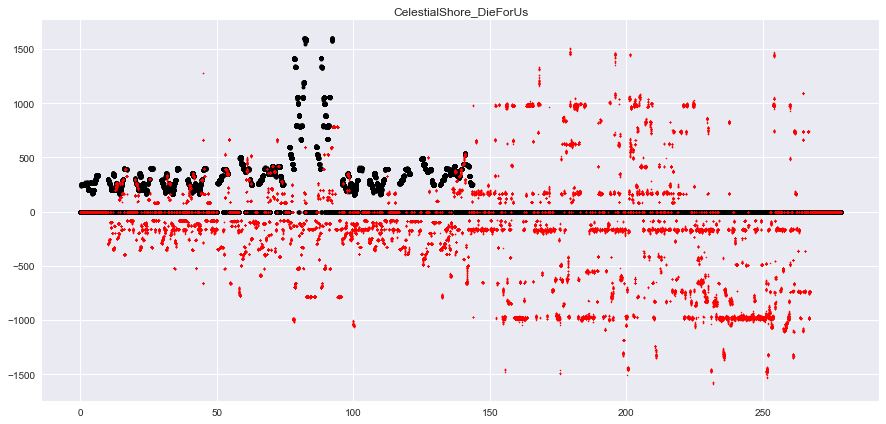

MusicDelta_Pachelbel


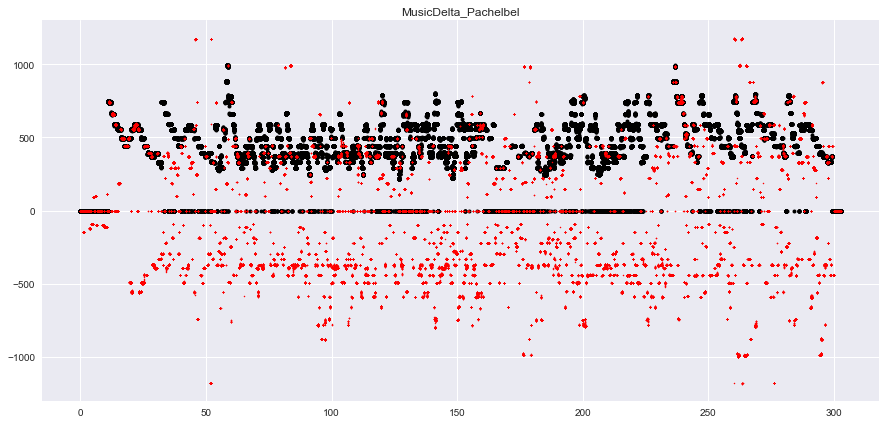

ChrisJacoby_BoothShotLincoln


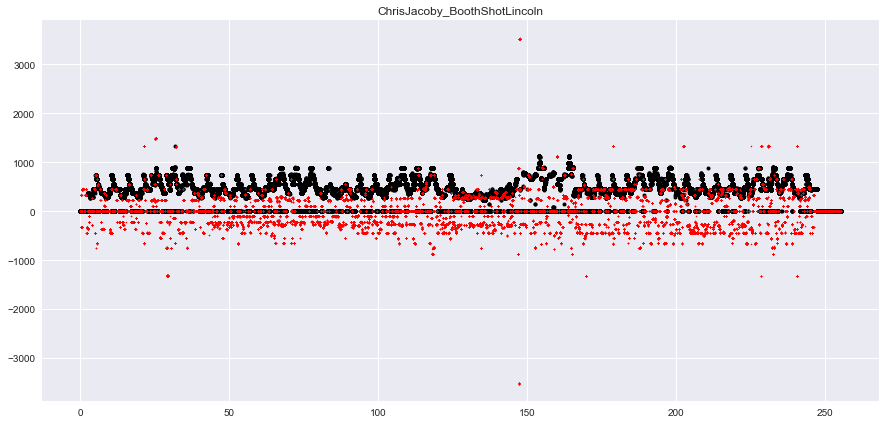

StrandOfOaks_Spacestation


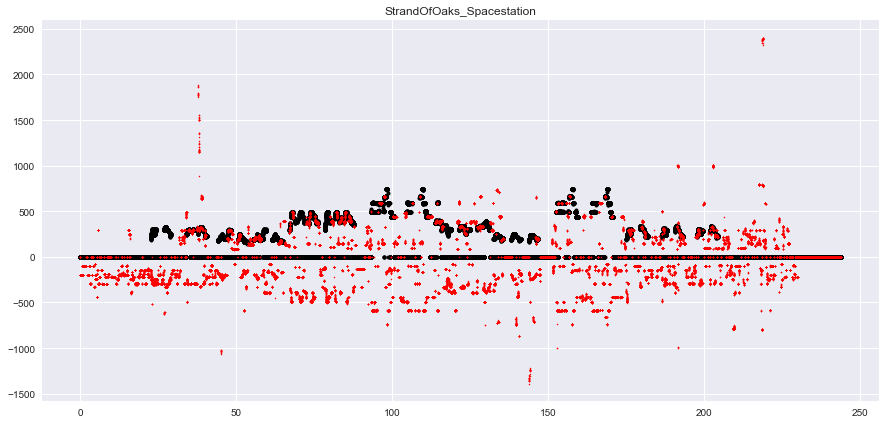

Phoenix_ElzicsFarewell


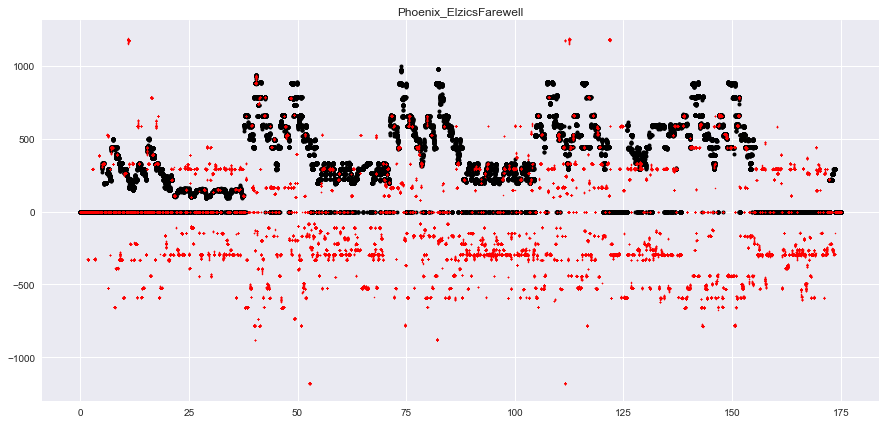

MusicDelta_Gospel
MatthewEntwistle_ImpressionsOfSaturn


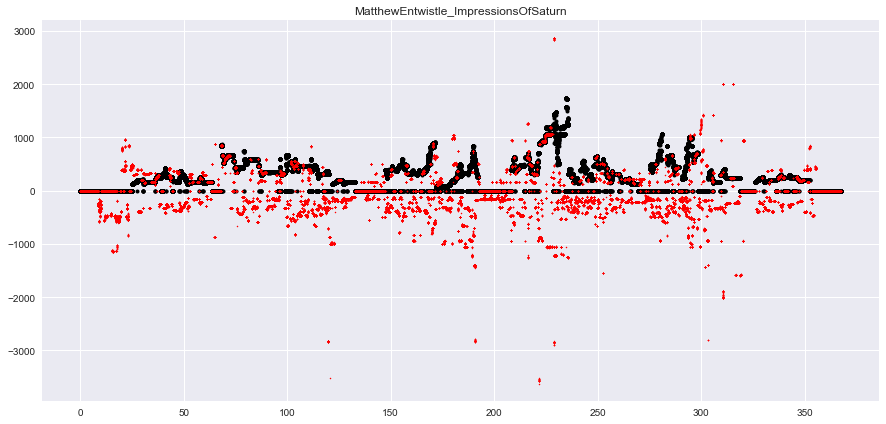

MatthewEntwistle_TheFlaxenField


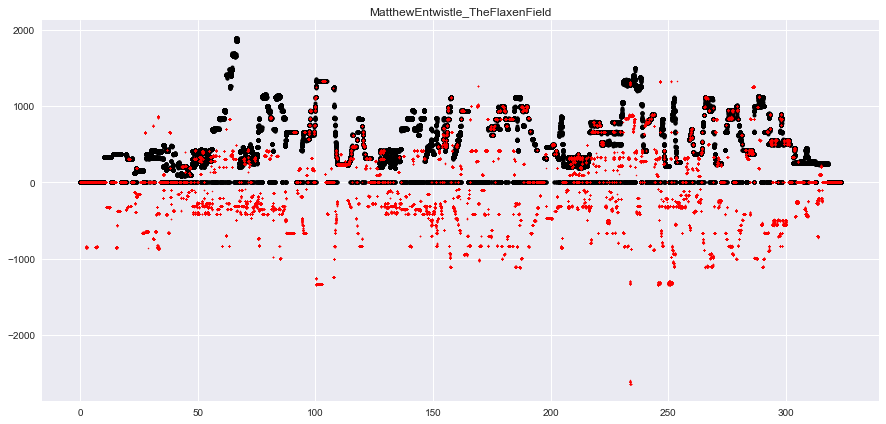

Phoenix_ScotchMorris


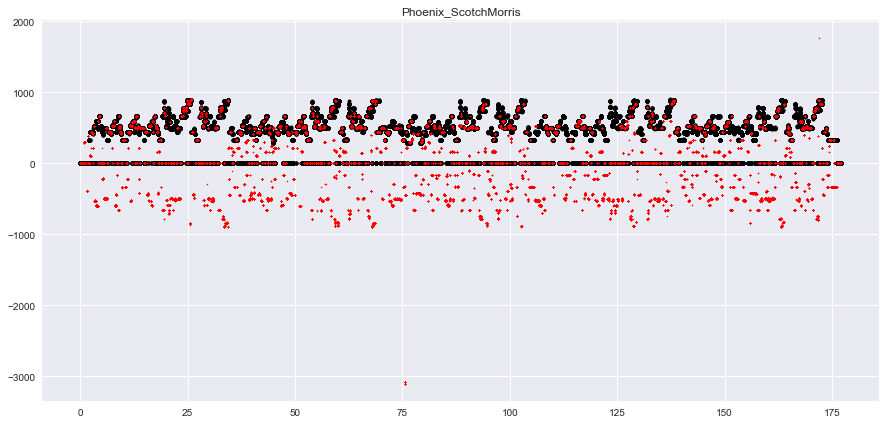

In [58]:
dcd = motif.contour_decoders.MaxDecoder(thresh=best_thresh)

all_mel_scores = []
for trackid in test_contours_sal.keys():
    print(trackid)
    if trackid == 'MusicDelta_Gospel':
        continue
    mtrack = mdb.MultiTrack(trackid)
    
    ctr = test_contours_sal[trackid]
    scores = test_melprobs[trackid]

    mel2 = mtrack.melody2_annotation
    mel2 = np.array(mel2).T
    ref_times, ref_freqs = (mel2[0], mel2[1])
    est_times, est_freqs = dcd.decode(ctr, scores)

    plt.figure(figsize=(15, 7))
    plt.title(trackid)
    plt.plot(ref_times, ref_freqs, '.k', markersize=8)
    plt.plot(est_times, est_freqs, '.r', markersize=3)
    plt.show()

    mel_scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
    all_mel_scores.append(mel_scores)

mel_scores_df = pd.DataFrame(all_mel_scores)
mel_scores_df.to_csv("Salamon_contourclf_mel2_scores.csv")

In [59]:
mel_scores_df.describe()

,Overall Accuracy,Raw Chroma Accuracy,Raw Pitch Accuracy,Voicing False Alarm,Voicing Recall
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.396332,0.622371,0.494997,0.226764,0.360586
std,0.117612,0.137939,0.157406,0.071728,0.105433
min,0.158053,0.324853,0.214484,0.057726,0.121706
25%,0.318063,0.530798,0.364826,0.208875,0.284730
50%,0.405581,0.671865,0.518097,0.237382,0.353853
75%,0.467154,0.712362,0.600840,0.270706,0.417415
max,0.632382,0.814585,0.744727,0.370975,0.559121
